In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib import font_manager
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from spynal.spikes import density
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import *
from plot_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

plt.style.use('../../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

# Load Data

In [4]:
norm = False
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'
grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
directory = pd.read_pickle(os.path.join(all_data_dir, data_class, f"{session}_lfp_chunked_20s", "directory"))

In [9]:
grid_results = compile_grid_results(session, grid_results_dir)

In [10]:
window, matrix_size, rank, all_results = combine_grid_results({'all': grid_results['all']})

# Sample Times

In [11]:
np.random.seed(42)
wake_bounds = section_times['wake']
anesthesia_bounds = (session_info['drugStart'][0] + 15*60, session_info['drugEnd'][1] - 15*60)

num_samples = 10

wake_times = np.sort(np.random.uniform(wake_bounds[0], wake_bounds[1], size=(num_samples,)))
anesthesia_times = np.sort(np.random.uniform(anesthesia_bounds[0], anesthesia_bounds[1], size=(num_samples,)))

# Get Data

In [25]:
matrix_size

1000

In [40]:
rank = 1000

In [41]:
all_signals = []
all_delases = []

# signals_to_make = ['deltaswap', 'gammaswap', 'deltaboost', 'gammaboost', 'deltarand', 'gammarand']
signals_to_make = []

iterator = tqdm(total=num_samples*2*3)

max_unstable_freq = 500

np.random.seed(42)

for tw, ta in zip(wake_times, anesthesia_times):
    
    lfp_w = load_window_from_chunks(tw, tw+15, directory)
    lfp_a = load_window_from_chunks(ta, ta+15, directory)

    signals = {}
    signals['original'] = dict(
        wake = lfp_w,
        anesthesia = lfp_a,
    )

    if len(signals_to_make) > 0:
    
        fft_w = np.fft.rfft(lfp_w.T)
        fft_a = np.fft.rfft(lfp_a.T)
        freqs = np.fft.rfftfreq(lfp_a.shape[0], d=dt)

        fft_w_mag = np.abs(fft_w)
        fft_w_phase = np.angle(fft_w)
        fft_a_mag = np.abs(fft_a)
        fft_a_phase = np.angle(fft_a)
    
        delta_inds = (freqs >= 0.5) & (freqs <= 4)
        gamma_inds = (freqs >= 30) & (freqs <= 80)

    # DELTASWAP
    if 'deltaswap' in signals_to_make:
        
        wake_delta = fft_w[:, delta_inds]
        anesthesia_delta = fft_a[:, delta_inds]
        
        # plt.plot(freqs[delta_inds], np.abs(wake_delta.mean(axis=0)))
        # plt.plot(freqs[delta_inds], np.abs(anesthesia_delta.mean(axis=0)))
        
        fft_w_deltaswap = deepcopy(fft_w)
        fft_w_deltaswap[:, delta_inds] = anesthesia_delta
        fft_a_deltaswap = deepcopy(fft_a)
        fft_a_deltaswap[:, delta_inds] = wake_delta
        
        signals['deltaswap'] = dict(
            wake=np.fft.irfft(fft_w_deltaswap).T,
            anesthesia=np.fft.irfft(fft_a_deltaswap).T,
        )

    # GAMMA SWAP
    if 'gammaswap' in signals_to_make:
    
        gamma_inds = (freqs >= 30) & (freqs <= 80)
        wake_gamma = fft_w[:, gamma_inds]
        anesthesia_gamma = fft_a[:, gamma_inds]
        
        # plt.plot(freqs[delta_inds], np.abs(wake_delta.mean(axis=0)))
        # plt.plot(freqs[delta_inds], np.abs(anesthesia_delta.mean(axis=0)))
        
        fft_w_gammaswap = deepcopy(fft_w)
        fft_w_gammaswap[:, gamma_inds] = anesthesia_gamma
        fft_a_gammaswap = deepcopy(fft_a)
        fft_a_gammaswap[:, gamma_inds] = wake_gamma
        
        signals['gammaswap'] = dict(
            wake=np.fft.irfft(fft_w_gammaswap).T,
            anesthesia=np.fft.irfft(fft_a_gammaswap).T,
        )

        
    
    # DELTA RANDOMIZE
    if 'deltarand' in signals_to_make:
        fft_w_phase_deltarand = deepcopy(fft_w_phase)
        flattened = fft_w_phase[:, delta_inds].flatten()
        np.random.shuffle(flattened)
        fft_w_phase_deltarand[:, delta_inds] = flattened.reshape(*fft_w_phase[:, delta_inds].shape)
        fft_w_deltarand = fft_w_mag*np.exp(1j * fft_w_phase_deltarand)
    
        fft_a_phase_deltarand = deepcopy(fft_a_phase)
        flattened = fft_w_phase[:, delta_inds].flatten()
        np.random.shuffle(flattened)
        fft_a_phase_deltarand[:, delta_inds] = flattened.reshape(*fft_a_phase[:, delta_inds].shape)
        fft_a_deltarand = fft_a_mag*np.exp(1j * fft_a_phase_deltarand)
    
        signals['deltarand'] = dict(
            wake=np.fft.irfft(fft_w_deltarand).T,
            anesthesia=np.fft.irfft(fft_a_deltarand).T,
        )

    # GAMMA RANDOMIZE
    if 'gammarand' in signals_to_make:
        fft_w_phase_gammarand = deepcopy(fft_w_phase)
        flattened = fft_w_phase[:, gamma_inds].flatten()
        np.random.shuffle(flattened)
        fft_w_phase_gammarand[:, gamma_inds] = flattened.reshape(*fft_w_phase[:, gamma_inds].shape)
        fft_w_gammarand = fft_w_mag*np.exp(1j * fft_w_phase_gammarand)
    
        fft_a_phase_gammarand = deepcopy(fft_a_phase)
        flattened = fft_w_phase[:, gamma_inds].flatten()
        np.random.shuffle(flattened)
        fft_a_phase_gammarand[:, gamma_inds] = flattened.reshape(*fft_a_phase[:, gamma_inds].shape)
        fft_a_gammarand = fft_a_mag*np.exp(1j * fft_a_phase_gammarand)
    
        signals['gammarand'] = dict(
            wake=np.fft.irfft(fft_w_gammarand).T,
            anesthesia=np.fft.irfft(fft_a_gammarand).T,
        )
    

    # DELTA BOOST
    if 'deltaboost' in signals_to_make:
        fft_w_mag_deltaboost = deepcopy(fft_w_mag)
        fft_w_mag_deltaboost[:, delta_inds] *=2
        fft_w_deltaboost = fft_w_mag_deltaboost* np.exp(1j * fft_w_phase)
    
        fft_a_mag_deltaboost = deepcopy(fft_a_mag)
        fft_a_mag_deltaboost[:, delta_inds] *=2
        fft_a_deltaboost = fft_a_mag_deltaboost* np.exp(1j * fft_a_phase)
    
        signals['deltaboost'] = dict(
            wake=np.fft.irfft(fft_w_deltaboost).T,
            anesthesia=np.fft.irfft(fft_a_deltaboost).T,
        )

    # GAMMA BOOST
    if 'gammaboost' in signals_to_make:
        fft_w_mag_gammaboost = deepcopy(fft_w_mag)
        fft_w_mag_gammaboost[:, gamma_inds] *=2
        fft_w_gammaboost = fft_w_mag_gammaboost* np.exp(1j * fft_w_phase)
    
        fft_a_mag_gammaboost = deepcopy(fft_a_mag)
        fft_a_mag_gammaboost[:, gamma_inds] *=2
        fft_a_gammaboost = fft_a_mag_gammaboost* np.exp(1j * fft_a_phase)
    
        signals['gammaboost'] = dict(
            wake=np.fft.irfft(fft_w_gammaboost).T,
            anesthesia=np.fft.irfft(fft_a_gammaboost).T,
        )

    delases = {}
    
    for key in signals.keys():
        delases[key] = {}
        for section in signals[key].keys():
            lfp = signals[key][section]
            delase = DeLASE(lfp, matrix_size=matrix_size, rank=rank, dt=dt, max_freq=500, max_unstable_freq=max_unstable_freq, device='cuda')
            delase.fit()
            delase.to('cpu')
            delases[key][section] = delase
    
            iterator.update()

    all_signals.append(signals)
    all_delases.append(delases)

iterator.close()

  0%|          | 0/60 [00:00<?, ?it/s]

In [52]:
stab_params = {}
stab_freqs = {}
delase_evals = {}

for ind, delases in enumerate(all_delases):
    for key in delases.keys():
        if key not in stab_params.keys():
            stab_params[key] = {}
            stab_freqs[key] = {}
            delase_evals[key] = {}
        for section in delases[key].keys():
            delase = delases[key][section]
            if section not in stab_params[key].keys():
                stab_params[key][section] = np.zeros((num_samples, len(delase.stability_params)))
                stab_freqs[key][section] = np.zeros((num_samples, len(delase.stability_freqs)))
                delase_evals[key][section] = np.zeros((num_samples, delase.DMD.A_havok_dmd.shape[0]))

            stab_params[key][section][ind] = delase.stability_params
            stab_freqs[key][section][ind] = delase.stability_freqs
            evals = torch.real(torch.linalg.eigvals((delase.DMD.A_havok_dmd - torch.eye(delase.DMD.A_havok_dmd.shape[0]))/dt))
            evals = torch.flip(torch.sort(evals).values, dims=(0,))
    
            delase_evals[key][section][ind] = evals

In [54]:
# i = 0
# for key in delase_evals.keys():
#     for section in delase_evals[key].keys():
#         if key == 'original':
#             plot_curve_with_se(delase_evals[key][section][:, :int(0.1*delase_evals[key][section].shape[1])], c=f"C{i}", label=f"{key}, {section}")
#         i += 1
# plt.legend()

In [ ]:
i = 0
for key in stab_params.keys():
    for section in stab_params[key].keys():
        if key == 'original':
            plot_curve_with_se(stab_params[key][section][:, :int(0.1*stab_params[key][section].shape[1])], c=f"C{i}", label=f"{key}, {section}")
        i += 1
plt.legend()

In [33]:
labels = []
mean_vals = []
se_vals = []
for key in stab_params.keys():
    for section in stab_params[key].keys():
        labels.append(f"{key}, {section}")
        mean_vals.append(stab_params[key][section][:, :int(0.1*stab_params[key][section].shape[1])].mean())
        shape_vals = stab_params[key][section][:, :int(0.1*stab_params[key][section].shape[1])].shape
        se_vals.append(stab_params[key][section][:, :int(0.1*stab_params[key][section].shape[1])].std()/(shape_vals[0]*shape_vals[1]))

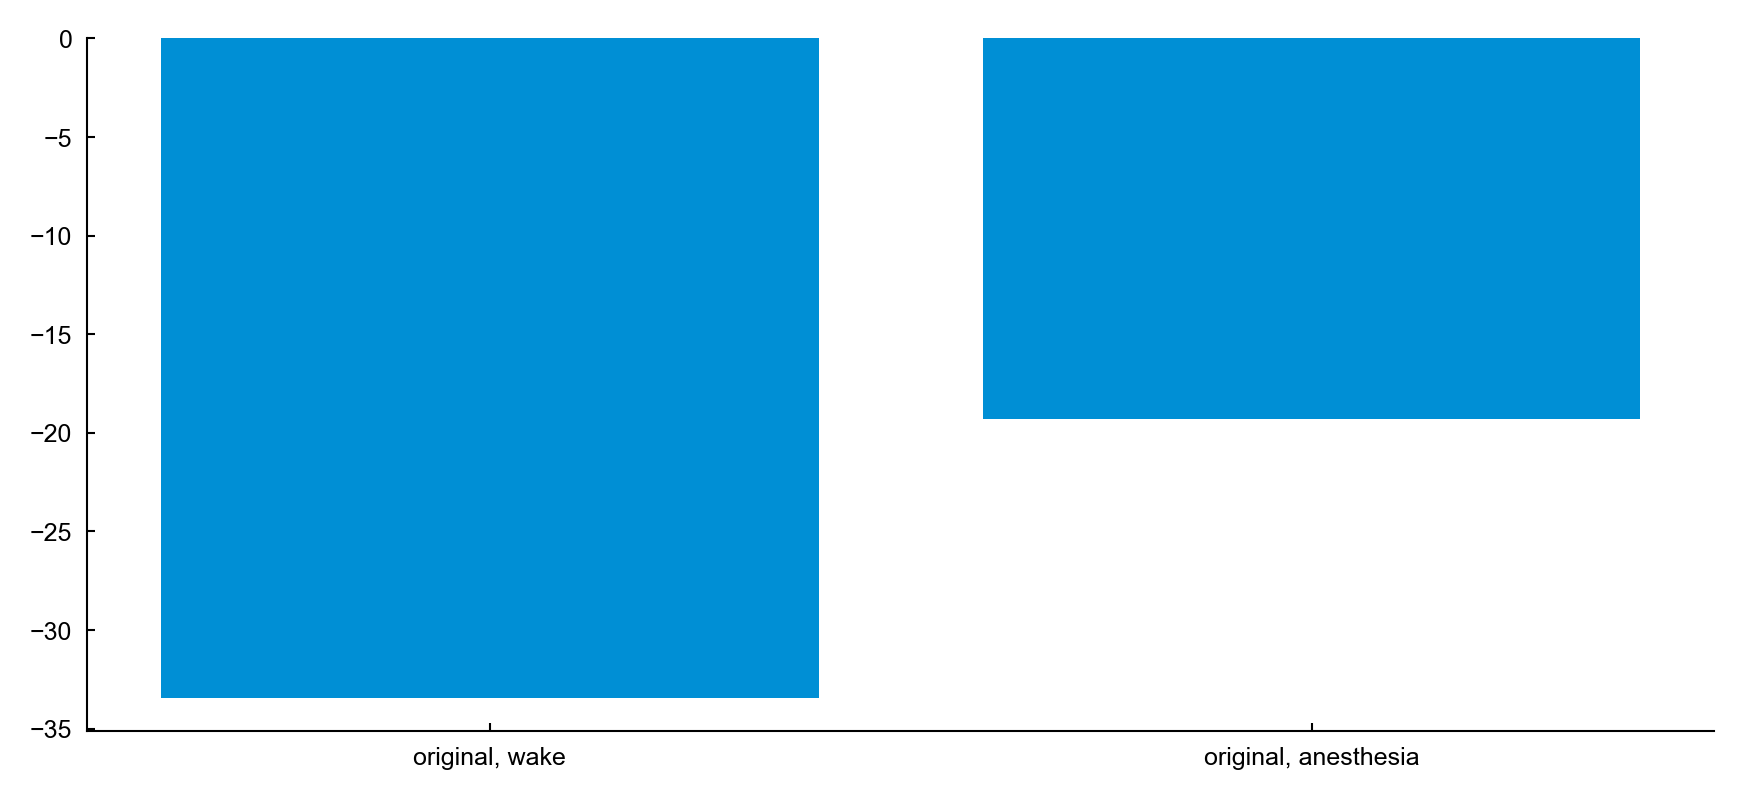

In [34]:
plt.figure(figsize=(7, 3))
plt.bar(labels, mean_vals, yerr=se_vals)
plt.show()

KeyError: 'gammarand'

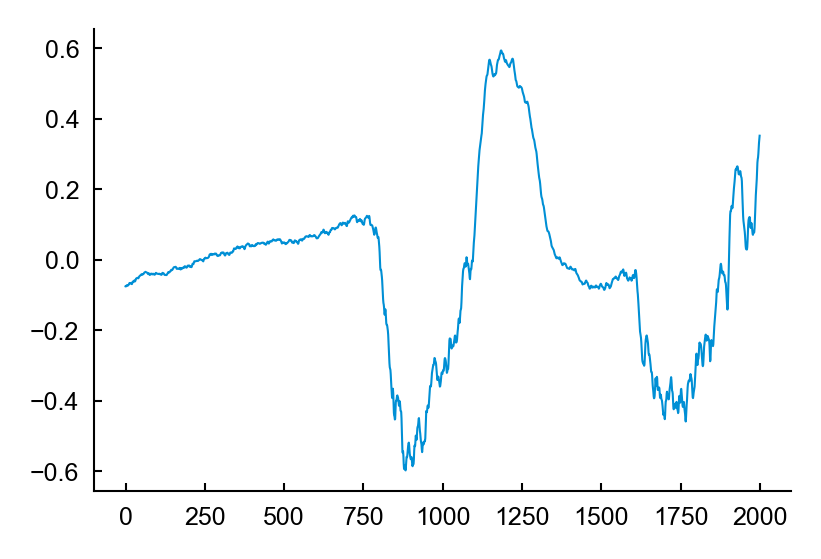

In [35]:
# plt.plot(signals['gammaswap']['anesthesia'][:2000, 0])
plt.plot(signals['original']['anesthesia'][:2000, 0], label='original')
plt.plot(signals['gammarand']['anesthesia'][:2000, 0], label='gammarand')
plt.plot(signals['deltarand']['anesthesia'][:2000, 0], label='deltarand')
plt.legend()

KeyError: 'gammarand'

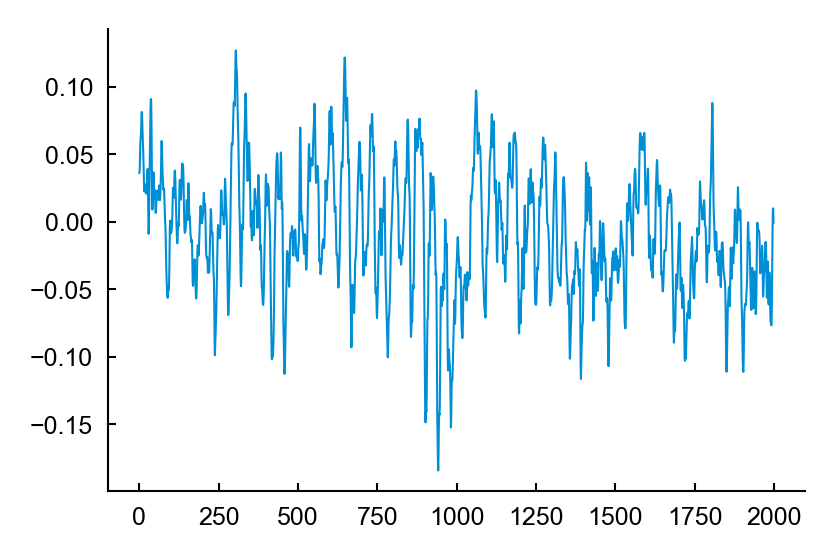

In [36]:
plt.plot(signals['original']['wake'][:2000, 0])
plt.plot(signals['gammarand']['wake'][:2000, 0])
plt.plot(signals['deltarand']['wake'][:2000, 0])

In [37]:
fft_gs = np.fft.rfft(signals['gammaswap']['anesthesia'][:, 0])
fft_or = np.fft.rfft(signals['original']['anesthesia'][:, 0])

KeyError: 'gammaswap'

In [38]:
freqs = np.fft.rfftfreq(n=15000, d=dt)

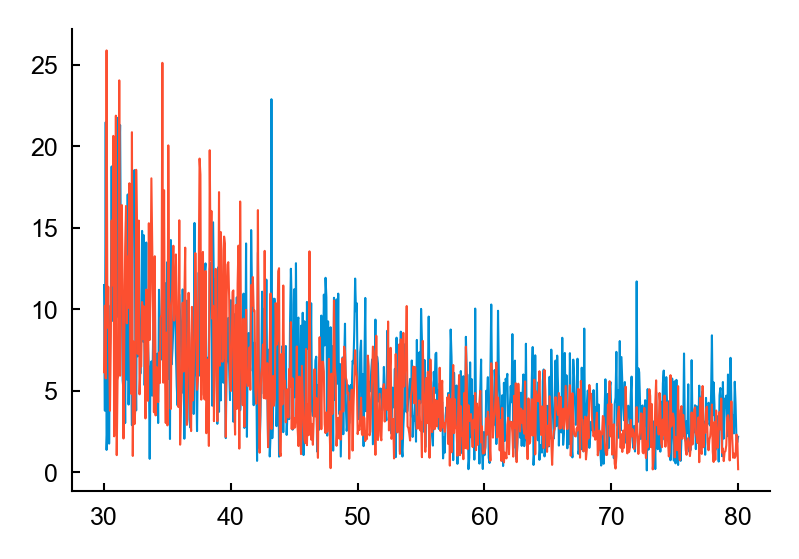

In [153]:
freq_min = 30
freq_max = 80
freq_inds = (freqs >= freq_min) & (freqs <= freq_max)
plt.plot(freqs[freq_inds], np.abs(fft_gs)[freq_inds])
plt.plot(freqs[freq_inds], np.abs(fft_or)[freq_inds])
# plt.plot(freqs[freq_inds], np.abs(fft_a_gammaswap[0])[freq_inds])
plt.show()

In [47]:
stab_params[key][section].shape

(10, 1494)

In [48]:
stab_params.keys()

dict_keys(['original', 'gammarand'])

In [49]:
stab_params[key][section].shape

(10, 1494)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


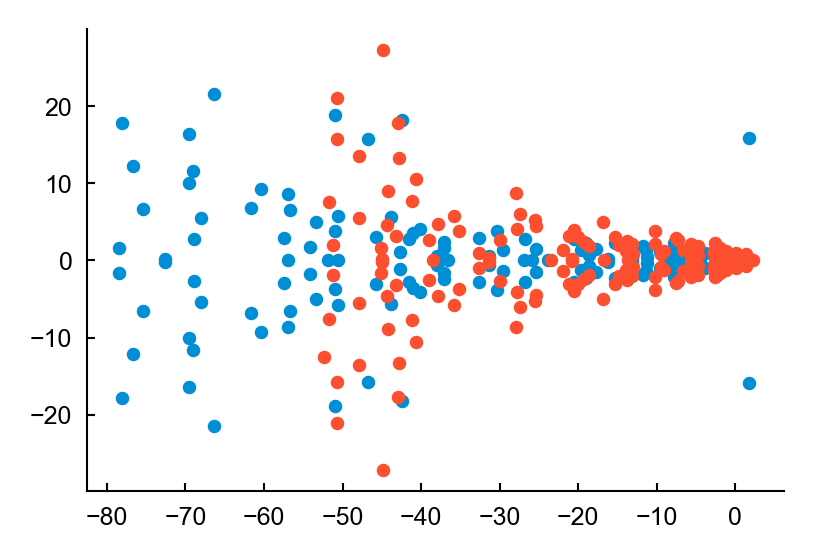

In [50]:
i = 0
for key in stab_params.keys():
    for section in stab_params[key].keys():
        if key == 'original':
            plt.scatter(stab_params[key][section][0, :int(0.1*stab_params[key][section].shape[1])], stab_freqs[key][section][0, :int(0.1*stab_params[key][section].shape[1])], s=5, alpha=1)
            # plot_curve_with_se(stab_params[key][section][:, :int(0.1*stab_params[key][section].shape[1])], c=f"C{i}", label=f"{key}, {section}")
            # raise ValueError
        i += 1
plt.legend()